In [18]:
# configuration of GPT-2

GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

- `vocab_size` refers to a vocabulary of 50,257 words, as used by the BPE tokenizer (see chapter 2).
- `context_length` denotes the maximum number of input tokens the model can handle via the positional embeddings (see chapter 2).
- `emb_dim` represents the embedding size, transforming each token into a 768-dimensional vector.
- `n_heads` indicates the count of attention heads in the multi-head attention
mechanism (see chapter 3).
- `n_layers` specifies the number of transformer blocks in the model, which we will cover in the upcoming discussion.
- `drop_rate` indicates the intensity of the dropout mechanism (0.1 implies a 10% random drop out of hidden units) to prevent overfitting (see chapter 3).
- `qkv_bias` determines whether to include a bias vector in the Linear layers of the multi-head attention for query, key, and value computations. We will initially disable this, following the norms of modern LLMs, but we will revisit it in chapter 6 when we load pretrained GPT-2 weights from OpenAI into our model (see chapter 6)

### A highlight of structure of GPT
<img src="mdfig\2025-04-06-18-53-18.png" width="50%" alt="描述"> 
<!-- ![](mdfig\2025-04-06-18-53-18.png) -->

In [12]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])

        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])

        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device = in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits
    
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps = 1e-5):
        super().__init__()

    def forward(self, x):
        return x

In [13]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim = 0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [19]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


Using `keepdim=True` in operations like mean or variance calculation ensures that the output tensor retains the **same number of dimensions as the input tensor**, even though the operation reduces the tensor along the dimension specified via dim. 

In [22]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        # unbiased=False: divided by n instead of n-1
        var = x.var(dim = -1, keepdim = True, unbiased = False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

- `LayerNorm` operaties on the last dimension(emb_dim) of the input tensor
- `scale` and `shift` are two trainable parameters (same dim as the input)
- 在LayerNorm的实现中，使用unbiased=False的原因是：​​为了直接计算输入数据的二阶中心矩（有偏方差），而非对总体方差的无偏估计​​。在归一化操作中，我们的目标​​并非估计总体参数​​，而是​​直接对当前输入数据进行标准化​​。
  - 归一化的目标是消除特征间的量纲差异​​，而非估计总体分布。因此直接用当前数据的均值和方差（分母为n）更合理。
  - 若使用unbiased=True，当特征维度较小时（如C=64），分母n-1会导致方差计算偏差增大，影响归一化后的数值稳定性。
  - 与深度学习框架的默认实现对齐​​（如PyTorch、TensorFlow）

In [24]:
torch.manual_seed(123)
torch.set_printoptions(sci_mode = False)
batch_example = torch.randn(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [26]:
ln = LayerNorm(emb_dim = 5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, unbiased = False, keepdim = True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [27]:
# feedforward network with GELU activation
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5*x*(1+torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 *torch.pow(x, 3))
        ))

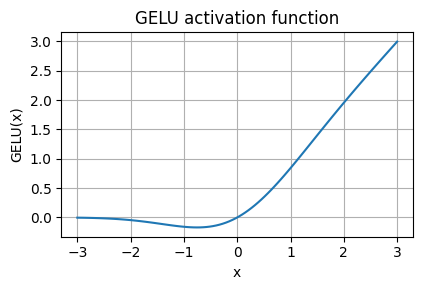

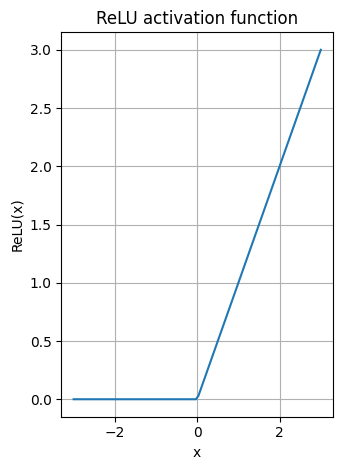

In [28]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [29]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            # (2, 3, 768)->(2, 3, 3072)
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            # (2,3,3072) -> (2,3,3072)
            GELU(),
            # (2,3,3072)->(2,3,768)
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]),
        )
    def forward(self, x):
        return self.layers(x)


In [30]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [44]:
from BuildingBlocks import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg["emb_dim"],
            d_out = cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads = cfg["n_heads"],
            dropout = cfg["drop_rate"],
            qkv_bias = cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
    def forward(self, x):

        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x

In [45]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


# Structure of GPT


<img src="mdfig\2025-04-06-21-32-35.png" width="50%" alt="描述"> 

In [46]:
# GPT DEF
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias = False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device = in_idx.device)
        )

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [47]:
# init
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


- PyTorch allows direct
access to all a model’s trainable parameters, including weights and biases, through the method `model.parameters()`

In [48]:
# cal num of params
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [49]:
# measure params in memory usage (Bytes)
total_size_bytes = total_params*4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [50]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        # Crops current context if it exceeds the supported context size, e.g., if LLM supports only 5 tokens, and the context size is 10, then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        # Focuses only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]
        # (batch, vocab_size)
        probas = torch.softmax(logits, dim = -1)
        # greedy
        idx_next = torch.argmax(probas, dim = -1, keepdim = True)
        idx = torch.cat((idx, idx_next), dim = 1)
    return idx

In [51]:
# test 
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

model.eval()
out = generate_text_simple(model = model, idx = encoded_tensor, max_new_tokens = 6, context_size = GPT_CONFIG_124M["context_length"])
print("Output:", out)
print("Output length:", len(out[0]))


encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])
Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [52]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


## ***Summary***

- ​**​Layer normalization​**​ stabilizes training by ensuring that each layer's outputs have a consistent mean and variance.  
- ​**​Shortcut connections​**​ skip one or more layers by feeding the output of one layer directly to a deeper layer, helping mitigate the vanishing gradient problem in deep neural networks (e.g., LLMs).  
- ​**​Transformer blocks​**​ are core components of GPT models, combining:  
  - Masked multi-head attention modules  
  - Fully connected feed-forward networks with GELU activation  
- GPT models are LLMs with ​**​repeated transformer blocks​**​, scaled from millions to billions of parameters.  
- ​**​Model sizes​**​ include:  
  `124M` / `345M` / `762M` / `1,542M` parameters  
  *(All implementable with the same `GPTModel` Python class)*  
- ​**​Text-generation capability​**​:  
  Sequentially decodes output tensors into human-readable text by predicting one token at a time based on input context.  
- ​**​Untrained GPT models​**​ produce incoherent text, emphasizing the necessity of training for coherent generation.  